# Power System Planning mid-term assignment WS 21/22
## By Emma Waßmer, 746306

In [568]:
#import section
import pandapower as pp
import pandapower.plotting as plot
import pandas as pd
import numpy as np
import pandapower.shortcircuit as sc

## Power flow modelling and analysis
The following network is the basis subject of this assignmant. The specific data is given in the task.
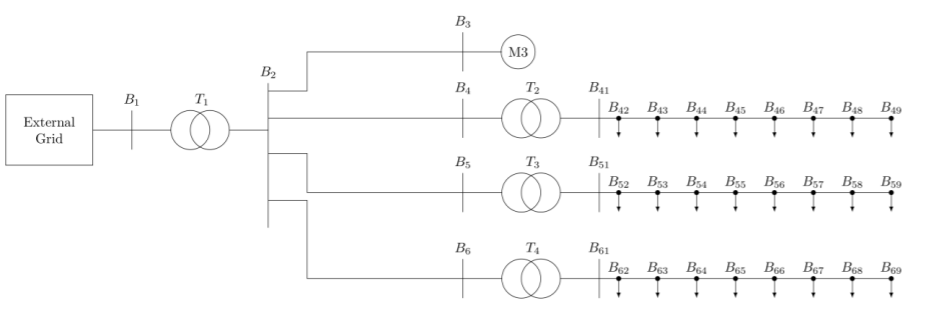

### Task 1: Model the test system in pandapower

In [569]:
net = pp.create_empty_network()

#create buses
bus1 = pp.create_bus(net, vn_kv=110., name="Bus 1")
bus2 = pp.create_bus(net, vn_kv=20., name="Bus 2")
bus3 = pp.create_bus(net, vn_kv=20., name="Bus 3")
bus4 = pp.create_bus(net, vn_kv=20., name="Bus 4")
bus5 = pp.create_bus(net, vn_kv=20., name="Bus 5")
bus6 = pp.create_bus(net, vn_kv=20., name="Bus 6")
bus41 = pp.create_bus(net, vn_kv=0.4, name="Bus 41")
bus51 = pp.create_bus(net, vn_kv=0.4, name="Bus 51")
bus61 = pp.create_bus(net, vn_kv=0.4, name="Bus 61")

#create external grid
ExGrid = pp.create_ext_grid(net, bus=bus1, s_sc_max_mva=100, s_sc_min_mva=80, rx_max=0.35, name="Grid Connection") #min SC-ratio=0.2??


#### Create medium voltage components
After creating the empty network and the buses and the external grid (see above), the medium voltage components are to implement. This includes the trasformers T1 - T4 as well as all lines on MV-side and the motor M3. This motor is realized as a static generator (sgen) with the type 'motor'.

In [570]:
#create transformers
T1 = pp.create_transformer(net, hv_bus=bus1, lv_bus=bus2, std_type="25 MVA 110/20 kV", name="T1")
T2 = pp.create_transformer(net, hv_bus=bus4, lv_bus=bus41, std_type="0.4 MVA 20/0.4 kV", name="T2")
T3 = pp.create_transformer(net, hv_bus=bus5, lv_bus=bus51, std_type="0.4 MVA 20/0.4 kV", name="T3")
T4 = pp.create_transformer(net, hv_bus=bus6, lv_bus=bus61, std_type="0.4 MVA 20/0.4 kV", name="T4")

#create lines
L23 = pp.create_line(net, from_bus=bus2, to_bus=bus3, length_km=5, std_type="NA2XS2Y 1x95 RM/25 12/20 kV", name="Line B2-B3")
L24 = pp.create_line(net, from_bus=bus2, to_bus=bus4, length_km=6, std_type="NA2XS2Y 1x95 RM/25 12/20 kV", name="Line B2-B4")
L25 = pp.create_line(net, from_bus=bus2, to_bus=bus5, length_km=7, std_type="NA2XS2Y 1x95 RM/25 12/20 kV", name="Line B2-B5")
L26 = pp.create_line(net, from_bus=bus2, to_bus=bus6, length_km=6, std_type="NA2XS2Y 1x95 RM/25 12/20 kV", name="Line B2-B6")

#create motor
M3 = pp.create_sgen(net, bus=bus3, p_mw=-3, sn_mva=10, q_mvar=-1, k=1.2, rx=7, type='motor')

#### Create similar low voltage components
Now, the low voltage components need to be implemented. This includes the LV lines and loads with related buses. In the given task, all low voltage lines have the same data and also all loads are similar. For a mor efficient code, the implementation of those components is realized with loops. For this purpose, the indices of the buses are important. For the verification of the right implementation of the network within the loops, the indices in the resulting tables must be looked at. Those tables are shown in the end of this first exercise.
##### Calculation for the loads:
    Power Factor = 0.95 indutive; active concumption: 2.2 kW
    alpha = arccos(0.95) = 18.19°
    Q = tan(18.19) * P = 0.723 kVAr 
    S = sqrt(P² + Q²) = 2.316 kVA

In [571]:
j = 2; i = 9
while j < 10:
    k = i+1; m = i+2
    pp.create_bus(net, vn_kv=0.4, name ="Bus 4"+str(j))  #create LV-buses B42-B49
    pp.create_load(net, i, p_mw=0.0022, q_mvar=0.000723, sn_mva=0.002316, name="Load 4"+str(j))   #create related loads L42-L49
    
    pp.create_bus(net, vn_kv=0.4, name ="Bus 5"+str(j))  #create LV-buses B52-B59
    pp.create_load(net, k, p_mw=0.0022, q_mvar=0.000723, sn_mva=0.002316, name="Load 5"+str(j))   #create related loads L52-L59
    
    pp.create_bus(net, vn_kv=0.4, name ="Bus 6"+str(j))  #create LV-buses B62-B69
    pp.create_load(net, m, p_mw=0.0022, q_mvar=0.000723, sn_mva=0.002316, name="Load 6"+str(j))   #create related loads L62-L69
    
    i = i+3 
    j = j+1

#create lines between the buses B41-B42; B51-B52; B61-B62 (cann't be created in the implemented loop below)
pp.create_line(net, 6, 9, length_km=0.1, std_type="48-AL1/8-ST1A 0.4", name="Line B41-B42")
pp.create_line(net, 7, 10, length_km=0.1, std_type="48-AL1/8-ST1A 0.4", name="Line B51-B52")
pp.create_line(net, 8, 11, length_km=0.1, std_type="48-AL1/8-ST1A 0.4", name="Line B61-B62")

j = 2; i = 9;    #set indices back to start values
while j < 9:
    k = i+1; m = i+2
    pp.create_line(net, i, i+3, length_km=0.1, std_type="48-AL1/8-ST1A 0.4", name="Line B4"+str(j)+"-B4"+str(j+1))
    pp.create_line(net, k, k+3, length_km=0.1, std_type="48-AL1/8-ST1A 0.4", name="Line B5"+str(j)+"-B5"+str(j+1))
    pp.create_line(net, m, m+3, length_km=0.1, std_type="48-AL1/8-ST1A 0.4", name="Line B6"+str(j)+"-B6"+str(j+1))
    j = j+1
    i = i+3 

#### Questions
##### 1a) What is the type of the 20 kV lines used? What information can you find from manufacturers? Is this typical for MV systems?
In the pandapower documentation, the details of the used 20 kV lines can be looked up ('Basic Standard Types', https://pandapower.readthedocs.io/en/develop/std_types/basic.html#lines). The name of the used cable is 'NA2XS2Y 1x95 RM/25 12/20 kV'. 'NA2XS2Y' is the type of the line, which is specified in the standard DIN VDE 0276-620. '1x95' is the nominal cross section. The abbreviation 'RM' indicates that the used cable is a round and stranded conductor. The conductor meterial of this type of cable is aluminiu, the conductor isolation is polyethylene DMP2. The NA2XS2Y cable type is utilized in very different applications, it is kind of an allrounder. It can be as used outside as well as inside, under the earth, in water and in cable ducts for power plants. In general, this type of cable is typical for medium voltage systems.
Source: "Mittelspannungskabel NA2XS2Y nach VDE 0276-620" from Kabelvertrieb Hesselmann (https://www.hesselmann.de/data-download/produktinfo/he-na2xs2y.pdf)

##### 1b) What is the type of the 400 V lines used? What information can you find from manufacturers? Is this typical for LV systems?
Again, the main data of the used type of cable can be find in the pandapower documentation (see link above). The name of the used low voltage cable is '48-AL1/8-ST1A 0.4'. This is an aluminium-steel rope which is specified in the standard DIN EN 50182. With the used steel core, the cable has an increased mechanical strength. Due to the low conductivity of steel, no complete steel ropes are used, but aluminium conductors with a steel core. This type of cable is typically used in overhead lines. The cable isn't isolated for other applications. In urban LV systems, the major part of the network is realized under the earth, consequently an other type of cable needs to be used here. In more rual ares with a lower population density, overhead lines aer still used in LV systems. In this case, the line, which is used within this exercise, can be applied.

##### 1c) Is this a radial or meshed system? Is this typical for distribution networks? Why?
The network is a radial network. The radial net topology is mainly used in low voltage networks. In high voltage distrinution  networks, usually the meshed topology is used. Both topologies have their pros and cons:
    
###### radial network
   - This type has an easy structure, consequently, the planning is easy and the build up relatively cheap. Futhermore, the          amount of switching actions is lower than in other topologies.
   - The huge disadvantage of this topologie is the lower supply reliability for the end consumers. If a line is damaged, all        loads behind this failure are cut off the net. There is no redundancy.

##### meshed network
   - This type has a very high supply reliability because in case of a failure, switching actions can gurantee that the loads        are fed through redundant supply lines.
   - The disadvantages of this topology are the higher complexity and the higher costs. 

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


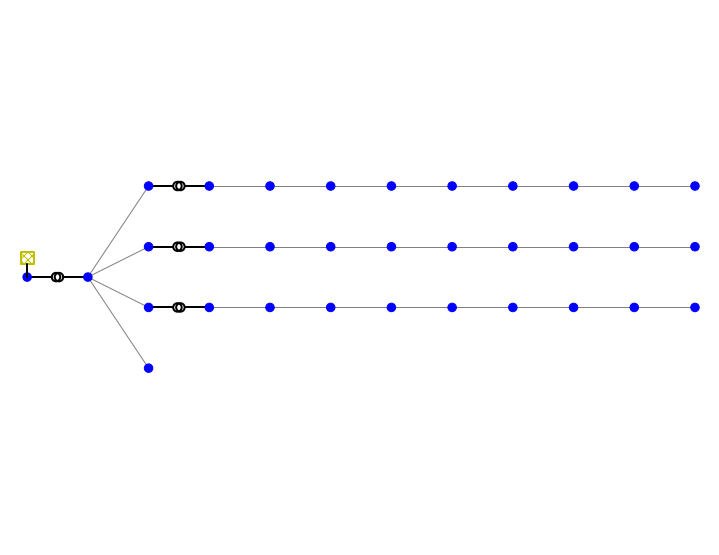

<AxesSubplot:>

In [572]:
#create simple plot for checking if the network design is as intended. In additon, this is necessary to create artificial 
#coordinates(geodata) which is needed for the colormaps below. 
plot.simple_plot(net, show_plot=True)

In [573]:
net.bus  #show all buses with characteristics

,name,vn_kv,type,zone,in_service
0,Bus 1,110.0,b,None,True
1,Bus 2,20.0,b,None,True
2,Bus 3,20.0,b,None,True
3,Bus 4,20.0,b,None,True
4,Bus 5,20.0,b,None,True
5,Bus 6,20.0,b,None,True
6,Bus 41,0.4,b,None,True
7,Bus 51,0.4,b,None,True
8,Bus 61,0.4,b,None,True
9,Bus 42,0.4,b,None,True


In [574]:
net.line  #show all lines with characteristics

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Line B2-B3,NA2XS2Y 1x95 RM/25 12/20 kV,1,2,5.0,0.3130,0.132,216.0,0.0,0.252,1.0,1,cs,True
1,Line B2-B4,NA2XS2Y 1x95 RM/25 12/20 kV,1,3,6.0,0.3130,0.132,216.0,0.0,0.252,1.0,1,cs,True
2,Line B2-B5,NA2XS2Y 1x95 RM/25 12/20 kV,1,4,7.0,0.3130,0.132,216.0,0.0,0.252,1.0,1,cs,True
3,Line B2-B6,NA2XS2Y 1x95 RM/25 12/20 kV,1,5,6.0,0.3130,0.132,216.0,0.0,0.252,1.0,1,cs,True
4,Line B41-B42,48-AL1/8-ST1A 0.4,6,9,0.1,0.5939,0.300,12.2,0.0,0.210,1.0,1,ol,True
5,Line B51-B52,48-AL1/8-ST1A 0.4,7,10,0.1,0.5939,0.300,12.2,0.0,0.210,1.0,1,ol,True
6,Line B61-B62,48-AL1/8-ST1A 0.4,8,11,0.1,0.5939,0.300,12.2,0.0,0.210,1.0,1,ol,True
7,Line B42-B43,48-AL1/8-ST1A 0.4,9,12,0.1,0.5939,0.300,12.2,0.0,0.210,1.0,1,ol,True
8,Line B52-B53,48-AL1/8-ST1A 0.4,10,13,0.1,0.5939,0.300,12.2,0.0,0.210,1.0,1,ol,True
9,Line B62-B63,48-AL1/8-ST1A 0.4,11,14,0.1,0.5939,0.300,12.2,0.0,0.210,1.0,1,ol,True


In [575]:
net.load #show all loads with characteristics

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load 42,9,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
1,Load 52,10,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
2,Load 62,11,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
3,Load 43,12,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
4,Load 53,13,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
5,Load 63,14,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
6,Load 44,15,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
7,Load 54,16,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
8,Load 64,17,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye
9,Load 45,18,0.0022,0.000723,0.0,0.0,0.002316,1.0,True,wye


In [576]:
net.trafo  #show all trafos with characteristics

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service
0,T1,25 MVA 110/20 kV,0,1,25.0,110.0,20.0,12.0,0.410,14.00,...,0,-9,9,1.5,0.0,0,False,1,1.0,True
1,T2,0.4 MVA 20/0.4 kV,3,6,0.4,20.0,0.4,6.0,1.425,1.35,...,0,-2,2,2.5,0.0,0,False,1,1.0,True
2,T3,0.4 MVA 20/0.4 kV,4,7,0.4,20.0,0.4,6.0,1.425,1.35,...,0,-2,2,2.5,0.0,0,False,1,1.0,True
3,T4,0.4 MVA 20/0.4 kV,5,8,0.4,20.0,0.4,6.0,1.425,1.35,...,0,-2,2,2.5,0.0,0,False,1,1.0,True


### Task 2: Run a power flow an display all the bus voltages, line currents and transformer loadings

In [577]:
#Run power flow ->  
pp.runpp(net) #no further specifications given -> use default configurations (Newton-Raphson algorithm!)

#Display all bus voltages
net.res_bus.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],['vm_pu']]

,vm_pu
0,1.000000
1,0.997485
2,0.983989
3,0.997542
4,0.997583
5,0.997542
6,0.995992
7,0.996033
8,0.995992
9,0.988142


In [578]:
#Display line currents and persentive line loading
net.res_line.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], ['i_ka', 'loading_percent']]

,i_ka,loading_percent
0,0.092772,36.814480
1,0.004549,1.805138
2,0.005326,2.113310
3,0.004549,1.805138
4,0.027544,13.116314
5,0.027543,13.115746
6,0.027544,13.116314
7,0.024162,11.505562
8,0.024161,11.505062
9,0.024162,11.505562


In [579]:
#display trafo loading
net.res_trafo.loc[[0,1,2,3], ['loading_percent']]

,loading_percent
0,12.582295
1,5.090975
2,5.090782
3,5.090975


#### Questions:
##### 2a) Are there any violations of the bus voltage, line, or transformers?
###### Bus voltage
There are no significant violations in the bus voltages. All the buses are within the acceptable 5% tolerance. But it is important to note, that the voltage decreases slightly with increasing distance to the transformer which connects the LV-grid to the MV part. This is a known result of the radial net topology. 
###### Lines
By looking at the results, there are several anomalies. First, the line which connects the motor M3 to the grid is the most loaded line. Because the oter branches (4, 5 and 6) have the same low voltage components, the line loadings of those branches are similar. Consequently, it's sufficient to look only on the lines from one branch. The MV lines of the branches have very low loadings with around 2%. But not only the loadings are lower, also the absolute values of the line current are lower than the most currents on LV side. Because the power needs to be tha same on both voltage levels, the current is lower if the voltage is higher (P = U * I). Behind the transformer on LV side, the line loadings are the highest with around 13%. With increasing distance to the transformer, the ines are lower loaded. The reason for this behaviour is again the radial net topology. The line B41-B42 must supply all loads in branch 4. Consequently, the loading of the subsequent lines is decreasing with ervery load. Therefore, the line B48-B49 has the lowest loading of the branch. 
All in all, all the line loadings are not critical. 
###### Transformers
By looking on the transformer results, it is conspicuous, that one transformer is significantly more loaded than the others. It's the transformer which connects the given network with the exteral grid. The loading loading is 12.58%. The other transformers are connecting one LV branch each. Like mentioned before, all three branches are similar. Accordingly, the transformerloadings of T2, T3 and T4 are all around 5.1%
    
##### 2b) Create and display a colormap of the buses showing blue for all voltages below 0.95, green for voltages between 0.95 and 1.05, and red for all voltages above 1.05 pu
note: the colormap which is displayed below is probably not like intended in the exercise. The grid structure can't be seen in it. In addition there is now geodata given. Because of this, I implemented a simple plot (see above), which creates artificial coordinates. Those coordinates are now used for the plot of the colormap below. In combination with the colormap in exercise 3b), it seems, that at least the coloring works.


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<AxesSubplot:>

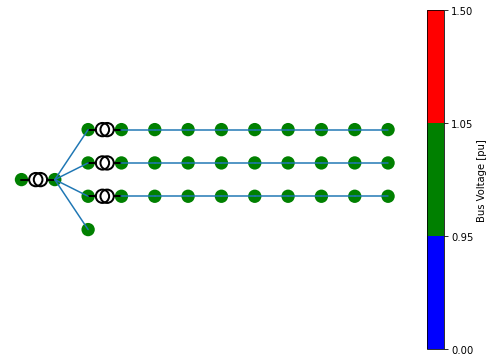

In [580]:
cmap_list=[((0.0,0.95), "blue"), ((0.95, 1.05), "green"), ((1.05, 1.5), "red")]
cmap, norm = plot.cmap_discrete(cmap_list)
lc = plot.create_line_collection(net)
tc = plot.create_trafo_collection(net)
bc = plot.create_bus_collection(net, cmap=cmap, norm=norm, size=0.2)#, linewidths=2)
plot.draw_collections([tc, lc, bc], figsize=(7,5))

### Task 3: Consider that the power consumption of every household is increased to 4 kW at 0.95 power factor and solve the power flow

###### Calculation for the Loads:
    Power Factor = 0.95 indutive; active concumption: 4 kW
    alpha = arccos(0.95) = 18.19°
    Q = tan(18.19) * P = 1.314 kVAr 
    S = sqrt(P² + Q²) = 4.21 kVA

In [581]:
#change P, Q and S of the loads
for i in range(0, 24):
    net.load.loc[i,"p_mw"]=0.004
    net.load.loc[i,"q_mvar"]=0.001314
    net.load.loc[i,"sn_mva"]=0.00421

#Run power flow
pp.runpp(net)

In [582]:
#Display all bus voltages
net.res_bus.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],['vm_pu']]

,vm_pu
0,1.000000
1,0.997395
2,0.983898
3,0.997368
4,0.997395
5,0.997368
6,0.994481
7,0.994508
8,0.994481
9,0.979847


In [583]:
#Display line currents
net.res_line.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], ['i_ka', 'loading_percent']]

,i_ka,loading_percent
0,0.092781,36.817897
1,0.004472,1.774794
2,0.005237,2.078085
3,0.004472,1.774794
4,0.051325,24.440568
5,0.051324,24.439835
6,0.051325,24.440568
7,0.045123,21.487277
8,0.045122,21.486627
9,0.045123,21.487277


In [584]:
#Display trafo loading
net.res_trafo.loc[[0,1,2,3], ['loading_percent']]

,loading_percent
0,12.777012
1,9.208737
2,9.208480
3,9.208737


#### Questions
##### 3a) Due to the change in the loads, the results of the power flow calculation are also different compared to the situation in the exercise before. 
###### Bus voltages:
The bus voltages are lower than before. The buses x5 til x9 (x is 4, 5 or 6) are below 0.95 p.u. Like before, the voltage in decreasing with increasing distance to the transformer. The last implemented buses (B49, B59, B69) have a bus voltage of 0.928 p.u. Consequently, not all voltages are within the tolerance of 5%.     
###### Lines: 
Over all, the persentive loading of the lines, which are connected to the loads, is increased compared to the case with 2.2 kW. Becuase nothing is changed with the motor M3, this line is approximately the same. The general findings from the case with 2.2 kW are still valid: With increasing distance to the transformer, the lines are lower loaded. But the single loadings are higher than in the case before. The lines right behind the transformer which must supply all loads of the feeder have a loading of 24.44% (before: 13.12%). The last lines which are only supplying one load, have a loading of 3.12% (before: 1.66%). The loadings are still not critical.
        
###### Transformers:
The transformer loading of T1 is only slightly higer than in the power flow calclation before (12.78% instead of 12.58%). This is plausible, because this transformer connects the complete given network with the external grid. As expected, the other transformers are higer loaded than before (9.21% instead of 5.1%). 

##### 3b) Create and display a colormap of the buses showing blue for all voltages below 0.95, green for voltages between 0.95 and 1.05, and red for all voltages above 1.05 pu.


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<AxesSubplot:>

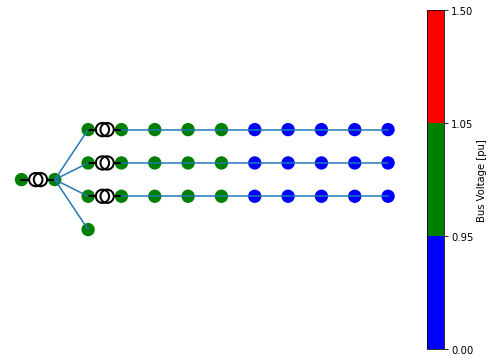

In [585]:
lc = plot.create_line_collection(net)#, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
bc = plot.create_bus_collection(net, cmap=cmap, norm=norm, size=0.2)#, linewidths=2)
tc = plot.create_trafo_collection(net)
plot.draw_collections([tc, lc, bc], figsize=(7,5))

### Task 4: Each house will purchase an electric vehicle with a 7 kW charger 
This load is in addition to their normal 2 kW with PF=0.95 load. They want to charge at the same time.

###### Calculation for the loads
    Power Factor = 0.95 indutive; active concumption without extra load: 2 kW
    alpha = arccos(0.95) = 18.19°
    Q = tan(18.19) * P = 0.657 kVAr
    P = 2 kW + 7 kW = 9 kW (with extra load)
    S = sqrt(P² + Q²) = 9.024 kVA

In [586]:
#change P, Q and S of the loads
for i in range(0, 24):
    net.load.loc[i,"p_mw"]=0.009
    net.load.loc[i,"q_mvar"]=0.000657
    net.load.loc[i,"sn_mva"]=0.009025

#Run power flow
pp.runpp(net)

In [587]:
#Display all bus voltages
net.res_bus.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],['vm_pu']]

,vm_pu
0,1.000000
1,0.997377
2,0.983880
3,0.997133
4,0.997124
5,0.997133
6,0.992804
7,0.992795
8,0.992804
9,0.961190


In [588]:
#Display line currents
net.res_line.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], ['i_ka', 'loading_percent']]

,i_ka,loading_percent
0,0.092783,36.818557
1,0.004985,1.978312
2,0.005685,2.256073
3,0.004985,1.978312
4,0.117150,55.785706
5,0.117151,55.786391
6,0.117150,55.785706
7,0.103606,49.336405
8,0.103608,49.337024
9,0.103606,49.336405


In [589]:
#Display trafo loading
net.res_trafo.loc[[0,1,2,3], ['loading_percent']]

,loading_percent
0,13.333338
1,20.624323
2,20.624569
3,20.624323


#### Questions
##### 4a) Is the system able to withstand this load?
The line loadings are again significantly higher than in the cases before (up to 55.8%), but this loading is no problem. Because of the radial topology, the lines can get loaded up to nearly 100%. But the voltage drop along the lines is very high. The buses 49, 59 and 69 only have bus voltages of 0.848 p.u.,which are much lower than the tolerance. Consequently, the system is not able to withstand the load because it leads to an not permissible voltage drop. 

##### 4b) If no, propose some solutions to alleviate the problem.
A possible solution is the change of the net topology to a design with a better voltage profile. There are several possibilities, for exapmple a ring topology. For this design, no second MV in-feed is necessary. A further improvement of the voltage profile can be realized with a second MV in-feed. This topology is called closed ring network. In the following picture, a schematic of such a network is shown
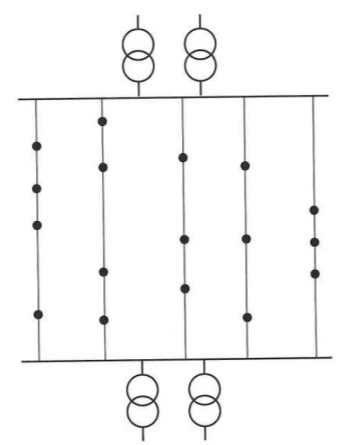
Picture source: Prof. Dr. Athanasios Krontiris, Power System Planing, lecture notes, slide 55
    

## Short circuit analysis
For this exercise, the same network like above is used.
### Task 1: Compute the maximum three-phase short-circuit currents for a solid fault (ZF=0 Ω)
In this and the following exercises, the function calc_sc() is applied. The net design and the parameters to calculate lead to some adjustment in the transfer parameters which are valid for all exercises within this Short circuit analysis part of this assignment:
- Topology: radial
- To calculate:  initial symmetrical short-circuit current, the short-circuit current peak ('ip'=True) the equivalent thermal short-circuit current ('ith'=True). This results has to be availiable for al branches ('branch_results'=True). For a higher clarity, it is important to set the parameter 'return_all_currents'=False. With this, only the highest sc-currents get displayed.
In this first task, the fault has the following characteristics:
- Type of fault: solid fault -> three phase balanced fault -> connection between every phase and ground with impedance Z=0 Ω
- r_fault_ohm = x_fault_ohm = 0 Ω
According the documentation of the calc_sc() function, the needed characteristics are given by the default values of the concerning transfer parameters. 


In [590]:
#perform short circuit calculation
sc.calc_sc(net, return_all_currents=False, topology="radial", ip=True, ith=True, branch_results=True)

Branch results are in beta mode and might not always be reliable, especially for transformers


#### 1a) Present the initial symmetrical short-circuit current, the short-circuit current peak, and the equivalent thermal short-circuit current at each bus.

In [591]:
net.res_bus_sc.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],
                   ['ikss_ka', 'ip_ka', 'ith_ka']]

,ikss_ka,ip_ka,ith_ka
0,0.587848,1.100741,0.590740
1,2.391179,4.770408,2.407425
2,2.072143,3.578809,2.079945
3,1.950672,3.324490,1.957491
4,1.886066,3.163606,1.892239
5,1.950672,3.324490,1.957491
6,10.917028,21.444482,10.986104
7,10.883470,21.306663,10.951297
8,10.917028,21.444482,10.986104
9,3.410214,5.021827,3.415835


##### 1b) Present the initial symmetrical short-circuit current, the short-circuit current peak, and the equivalent thermal short-circuit current at each line

In [592]:
net.res_line_sc

,ikss_ka,ip_ka,ith_ka
0,1.725733,3.088911,1.732230
1,1.950672,3.324490,1.957491
2,1.886066,3.163606,1.892239
3,1.950672,3.324490,1.957491
4,3.410214,5.021827,3.415835
5,3.405145,5.013973,3.410753
6,3.410214,5.021827,3.415835
7,1.946556,2.828877,1.949389
8,1.944859,2.826363,1.947690
9,1.946556,2.828877,1.949389


##### 1c) What is the difference between the three values of current computed at each node or line?
If a short circuit occures in a network, a short-circuit current arises and affects the net. This current can be described with different characteristics. The three most important are: 
###### initial symmetrical short-circuit current (ikss_ka)
    Is the effective value (RMS) of the symmetrical short circuit current at the moment in which the fault occures. 
###### short-circuit peak current (ip_ka)
    Is the largest instantenous value of the short circuit current which occures. This is always at the first AC peak after the fault occured
###### equivalent thermal short-circuit current (ith_ka)
    Is not a real current but a auxilary value. It is equal to the effective value of an AC current which would have the same thermal effects like the short circuit current during the time of the short circuit.

##### 1d) Which standard is used to compute the short-circuit currents? Explain  Briefly 
According the pandapower documentaion, the calc_sc-function applies the method of the equivalent voltage source which is formalized in DIN/IEC EN 60909.
In this method, an equivalent voltage is applied at the position of the short circuit. For the determination of the short-circuit currenst, simplifications are made:
- All other active voltages get short circuited. 
- All load impedances are neglected.
- All shut admittances of the lines are neglected
- All transformers are neglected 
- The equivalent volage is dependent of the rated voltage and a voltage factor which is given in the standard DIN/IEC EN 60909

With those simplifications, the short-circuit currents can be calculated with the short-circuit impedance.  


### Task 2: Deactivate the contribution of the large motor and re-compute the maximum threephase short-circuit currents for a solid fault (ZF=0 Ω).
In this task, the motor M3 is taken out of service. Beside this, the short circuit analysis has the same details like in the fist task. Consequently, the transfer parameters are the same.

In [593]:
#Taking the motor M3 out of service
net.sgen.in_service = False

#Perform the short circuit calculation
sc.calc_sc(net, return_all_currents=False, topology="radial", ip=True, ith=True, branch_results=True)

Branch results are in beta mode and might not always be reliable, especially for transformers


##### 2a) Present the initial symmetrical short-circuit current, the short-circuit current peak, and the equivalent thermal short-circuit current at each bus.

In [594]:
net.res_bus_sc.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],
                   ['ikss_ka', 'ip_ka', 'ith_ka']]

,ikss_ka,ip_ka,ith_ka
0,0.524864,1.011668,0.527447
1,2.044769,4.280510,2.058661
2,1.725733,3.088911,1.732230
3,1.668078,2.924842,1.673910
4,1.612832,2.777194,1.618110
5,1.668078,2.924842,1.673910
6,9.335478,19.207832,9.394547
7,9.306782,19.076889,9.364782
8,9.335478,19.207832,9.394547
9,2.916176,4.323152,2.920983


##### 2b) Present the initial symmetrical short-circuit current, the short-circuit current peak, and the equivalent thermal short-circuit current at each line

In [595]:
net.res_line_sc


,ikss_ka,ip_ka,ith_ka
0,1.725733,3.088911,1.732230
1,1.668078,2.924842,1.673910
2,1.612832,2.777194,1.618110
3,1.668078,2.924842,1.673910
4,2.916176,4.323152,2.920983
5,2.911841,4.316336,2.916637
6,2.916176,4.323152,2.920983
7,1.664558,2.430072,1.666981
8,1.663108,2.427905,1.665528
9,1.664558,2.430072,1.666981


In generel, it must be added, that in the radial low voltage network the resulting currents from the short circuit analysis are decreasing with increasing distance to the transformator. This is because of the increasing line impedances. This change of the values can be seen in all tasks concerning the short circuit analysis.  

##### 2c) Compare to the values of Task 1 and explain the difference.
###### Buses
The calculated values are slightly lower than before, but still in the same range. Because the only difference comapred to task 1 is tho motor M3, which is out of service now, this must be the root cause. If the motor is active, it is reponsible for a part of the short circuit current. If the motor is deactivated, this part does not occure and therefore, the short circuit currents are lower. 
###### Lines
Like with the buses, the values are slightly lower than in task 1 but in the same range. Only the values from the line with the index 0 (Line B2-B3) are exacty the same like before. In the table above only the maximum short circuit currents per line are listed. For getting this value, the currents for one line are calculated for every short circuit locations (every bus) and the highest value is displayed. This is generally the bus which is directly connected to the line. In the case of Line B2-B3, the maximum values are generated if the fault is in Bus B3 which connects the Motor M3. Because M3 is behind the fault location, its impedance isn't taken into account in the short circuit impedance in task 1. For the calculation of all other lines, M3 must be taken into account in task 1. In task 2, M3 is taken out of service, so the impedance does not effect the result of any line. Consequently, the results from line B2-B3 are the same in task 1 and 2 while the reults from all other lines are slightly below.

### Task 3: Compute the maximum three-phase short-circuit currents with fault impedance  ZF=1+j1.5 Ω
In this task, the fault impedance is changed. Compared to task 1, the following values have to be changed for the sc calculation: r_fault_ohm=1.0, x_fault_ohm=1.5

In [596]:
# Taking motor M3 back in service
net.sgen.in_service = True

#Perform the sc calculation
sc.calc_sc(net, r_fault_ohm=1.0, x_fault_ohm=1.5, topology="radial", ip=True, ith=True, 
           branch_results=True, return_all_currents=False)

Branch results are in beta mode and might not always be reliable, especially for transformers


##### 3a) Present the initial symmetrical short-circuit current, the short-circuit current peak, and the equivalent thermal short-circuit current at each bus.

In [597]:
net.res_bus_sc.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],
                   ['ikss_ka', 'ip_ka', 'ith_ka']]

,ikss_ka,ip_ka,ith_ka
0,0.581048,1.084834,0.583878
1,1.947408,3.612483,1.957422
2,1.735275,2.924297,1.741334
3,1.633002,2.730896,1.638397
4,1.586590,2.622846,1.591574
5,1.633002,2.730896,1.638397
6,1.720473,2.463641,1.725087
7,1.715603,2.456747,1.720204
8,1.720473,2.463641,1.725087
9,0.628687,0.916789,0.630315


##### 3b) Present the initial symmetrical short-circuit current, the short-circuit current peak, and the equivalent thermal short-circuit current at each line

In [598]:
net.res_line_sc

,ikss_ka,ip_ka,ith_ka
0,1.388865,2.434400,1.393715
1,1.633002,2.730896,1.638397
2,1.586590,2.622846,1.591574
3,1.633002,2.730896,1.638397
4,0.628687,0.916789,0.630315
5,0.627945,0.915733,0.629571
6,0.628687,0.916789,0.630315
7,0.412592,0.608710,0.413627
8,0.412338,0.608346,0.413372
9,0.412592,0.608710,0.413627


##### 3c) Compare to the values of Task 1 and explain the difference.
###### Buses
By applying the fault impedance, especially one bus per branch has significant differant values than in the first task. It's the buses with the indices 6, 7 and 8. Those are the buses B41, B51 and B61 which are located right behind the transformers. Consequently those buses are the ones which are the closest to the fault location. Because of the now added fault impedance, the flowing short circuit current is smaller (I=U/Z). The biggest effect can be seen at the buses which are very close to the transformer, but also for the other buses, smaller values are indicated.
###### Lines
The resulting values from the lines are also below those from task 1. The explanation for this is again the added fault impedance. Due to the higher impedance, the current decreases (I=U/Z) 

### Task 4: Compute the maximum two-phase short-circuit currents for a solid fault (ZF=0 Ω).
In this task, an other type fo fault is applied. Compared to task 1, the following parameter must be changed for the sc calculation: fault='2ph'

In [599]:
#Perform the sc calculation
sc.calc_sc(net, fault='2ph', return_all_currents=False, topology="radial", ip=True, ith=True, branch_results=True)

Branch results are in beta mode and might not always be reliable, especially for transformers


##### 4a) Present the initial symmetrical short-circuit current, the short-circuit current peak, and the equivalent thermal short-circuit current at each bus.

In [600]:
net.res_bus_sc.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],
                   ['ikss_ka', 'ip_ka', 'ith_ka']]

,ikss_ka,ip_ka,ith_ka
0,0.517529,0.965203,0.520076
1,2.117232,4.196928,2.131617
2,1.840939,3.164973,1.847870
3,1.727192,2.932635,1.733230
4,1.669988,2.791533,1.675453
5,1.727192,2.932635,1.733230
6,9.666311,18.871120,9.727473
7,9.636598,18.750845,9.696654
8,9.666311,18.871120,9.727473
9,3.019521,4.442634,3.024498


##### 4b) Present the initial symmetrical short-circuit current, the short-circuit current peak, and the equivalent thermal short-circuit current at each line.

In [601]:
net.res_line_sc

,ikss_ka,ip_ka,ith_ka
0,1.494529,2.675075,1.500155
1,1.727192,2.932635,1.733230
2,1.669988,2.791533,1.675453
3,1.727192,2.932635,1.733230
4,3.019521,4.442634,3.024498
5,3.015032,4.435693,3.019998
6,3.019521,4.442634,3.024498
7,1.723547,2.503309,1.726056
8,1.722045,2.501085,1.724551
9,1.723547,2.503309,1.726056


##### 4c) Compare to the values of Task 1 and explain the difference.
The indicated short-circuit currents are smaller than the ones in task 1. This is because of the different short circuit type. In task 1, a 3-phase short circuit applied, this type of short circuit is symmetric. Now, a two-phase short-circuit and therfore unsymmetric short-circuit is applied. In theory, the 2-phase short-circuit currents must be 0.5 * sqrt(3) times the 3-phase short-circuit current from task 1 ( I<sub>ph2</sub> = 0.5 * sqrt(3) * I<sub>ph3</sub>). The computed values do not fit perfectly to this formula but approximately. The deviations might be due to rounding.
